# Этапы решения задачи машинного обучения:
# 1. Постановка задачи
- Определение цели: классификация ирисов на setosa/virginica
- Выбор типа обучения: контролируемое обучение (бинарная классификация)

# 2. Сбор и подготовка данных
- Загрузка данных из CSV
- Фильтрация только нужных классов
- Преобразование категориальных меток в числовые

# 3. Разведочный анализ данных (EDA)
- Анализ статистик данных
- Визуализация распределений
- Проверка на выбросы и пропущенные значения

# 4. Предобработка данных
- Нормализация/стандартизация (при необходимости)
- Разделение на обучающую и тестовую выборки

# 5. Выбор модели
- Линейный классификатор (логистическая регрессия или SVM)

# 6. Обучение модели
- Инициализация параметров
- Оптимизация функции потерь
- Подбор гиперпараметров

# 7. Оценка модели
- Метрики качества: accuracy, precision, recall, F1-score
- Матрица ошибок
- Кросс-валидация

# 8. Прогнозирование
- Предсказание на новых данных
- Интерпретация результатов

# 9. Деплой и мониторинг
- Внедрение модели в production
- Мониторинг качества предсказаний



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, classification_report,
                           confusion_matrix, ConfusionMatrixDisplay)
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings('ignore')

In [2]:
# 1. Загрузка и изучение данных
url = "https://raw.githubusercontent.com/yakushinav/ipk/refs/heads/main/iris.csv"
df = pd.read_csv(url)

print("Первые 5 строк данных:")
print(df.head())
print("\nИнформация о данных:")
print(df.info())
print("\nСтатистика данных:")
print(df.describe())
print("\nРаспределение классов:")
print(df['species'].value_counts())

Первые 5 строк данных:
   sepal_length  sepal_width  petal_length  petal_width      species
0           5.1          3.5           1.4          0.2  Iris-setosa
1           4.9          3.0           1.4          0.2  Iris-setosa
2           4.7          3.2           1.3          0.2  Iris-setosa
3           4.6          3.1           1.5          0.2  Iris-setosa
4           5.0          3.6           1.4          0.2  Iris-setosa

Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   sepal_length  150 non-null    float64
 1   sepal_width   150 non-null    float64
 2   petal_length  150 non-null    float64
 3   petal_width   150 non-null    float64
 4   species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB
None

Статистика данных:
       sepal_length  sepal_width  petal_length  petal_width

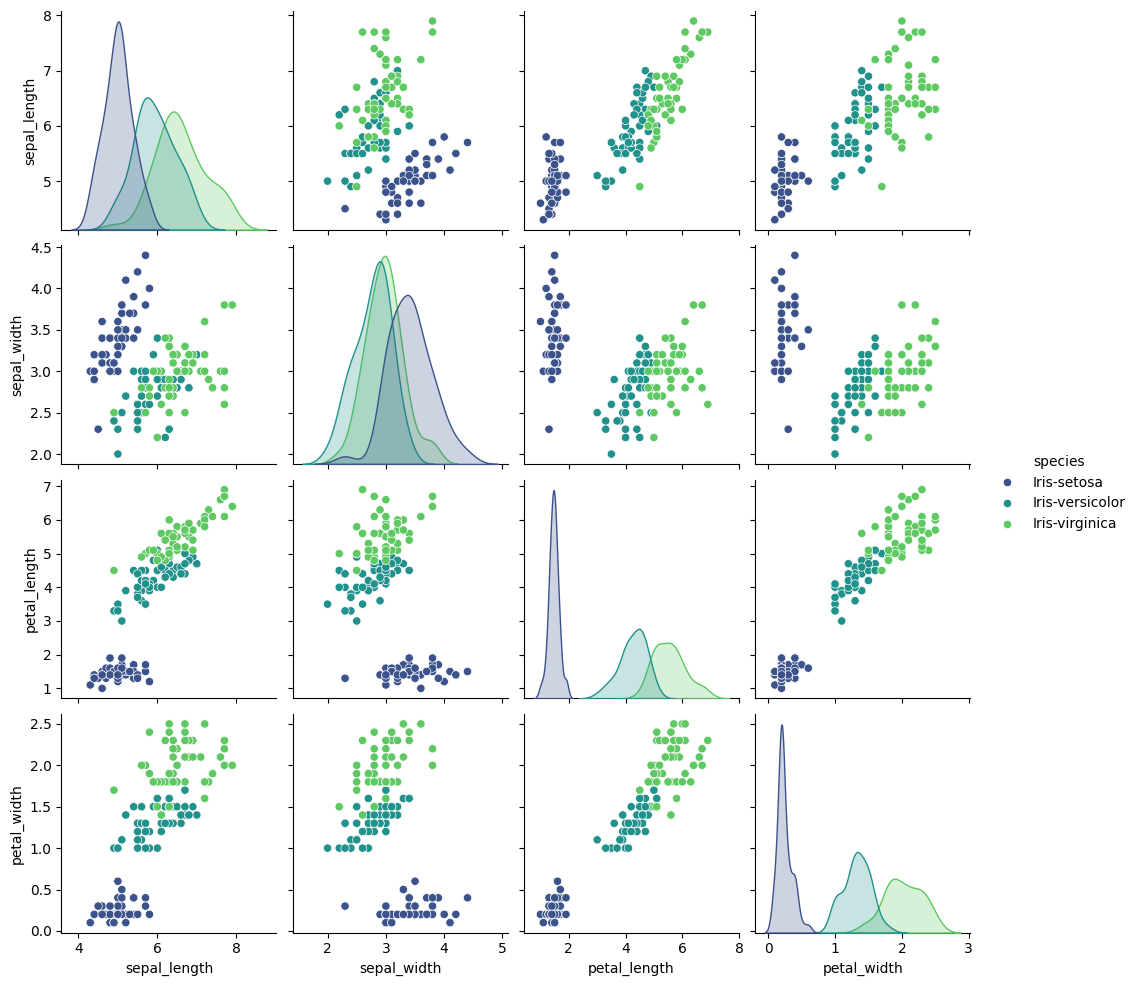

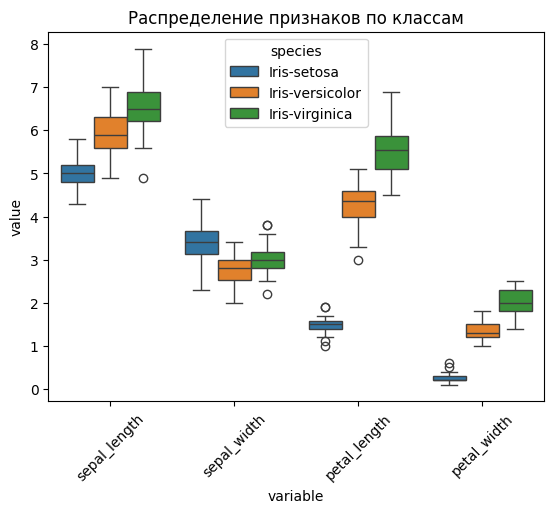

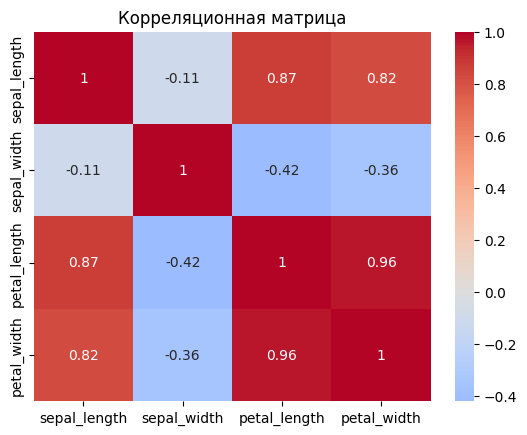

In [3]:
# 2. Визуализация данных

# Pairplot для визуализации взаимосвязей

sns.pairplot(df, hue='species', palette='viridis')
plt.show()

# Boxplot для каждого признака
df_melted = df.melt(id_vars=['species'],
                   value_vars=['sepal_length', 'sepal_width', 'petal_length', 'petal_width'])
sns.boxplot(data=df_melted, x='variable', y='value', hue='species')
plt.title('Распределение признаков по классам')
plt.xticks(rotation=45)
plt.show()

# Корреляционная матрица
numeric_df = df.drop('species', axis=1)
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Корреляционная матрица')
plt.show()

In [4]:
# Разделение на признаки и метку
X = df.drop('species', axis=1)
y = df['species']

# Сохраняем имена признаков
feature_names = X.columns.tolist()

# Кодирование меток
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

print(f"\nКлассы после кодирования: {label_encoder.classes_}")
print(f"Метки: {np.unique(y_encoded)}")
print(f"Имена признаков: {feature_names}")

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.3, random_state=42, stratify=y_encoded
)

print(f"\nРазмеры выборок:")
print(f"Обучающая: {X_train.shape}")
print(f"Тестовая: {X_test.shape}")
print(f"Распределение классов в train: {np.bincount(y_train)}")
print(f"Распределение классов в test: {np.bincount(y_test)}")


Классы после кодирования: ['Iris-setosa' 'Iris-versicolor' 'Iris-virginica']
Метки: [0 1 2]
Имена признаков: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']

Размеры выборок:
Обучающая: (105, 4)
Тестовая: (45, 4)
Распределение классов в train: [35 35 35]
Распределение классов в test: [15 15 15]


In [5]:
# 4. Создание и обучение моделей
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(random_state=42, probability=True),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100)
}

# Создание pipeline с стандартизацией
pipelines = {}
results = {}

for name, model in models.items():
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model)
    ])
    pipelines[name] = pipeline

# Обучение и оценка моделей
print("\n=== Оценка моделей ===")
for name, pipeline in pipelines.items():
    # Обучение на DataFrame с именами признаков
    pipeline.fit(X_train, y_train)

    # Предсказание на DataFrame с именами признаков
    y_pred = pipeline.predict(X_test)
    y_pred_proba = pipeline.predict_proba(X_test)

    # Метрики
    accuracy = accuracy_score(y_test, y_pred)
    cv_scores = cross_val_score(pipeline, X, y_encoded, cv=5)

    results[name] = {
        'accuracy': accuracy,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'model': pipeline,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

    print(f"\n{name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Cross-val Accuracy: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")



=== Оценка моделей ===

Logistic Regression:
Accuracy: 0.9111
Cross-val Accuracy: 0.9600 (±0.0389)

SVM:
Accuracy: 0.9333
Cross-val Accuracy: 0.9667 (±0.0211)

Decision Tree:
Accuracy: 0.9111
Cross-val Accuracy: 0.9533 (±0.0340)

Random Forest:
Accuracy: 0.8889
Cross-val Accuracy: 0.9667 (±0.0211)


(0.8, 1.0)

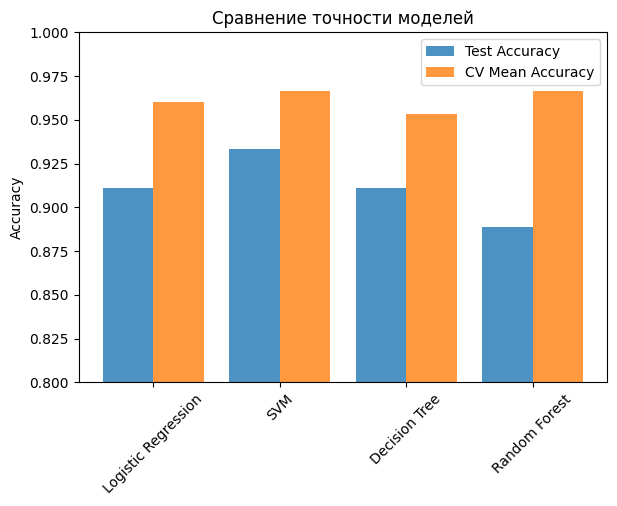

In [6]:
# 5. Визуализация результатов
plt.figure(figsize=(15, 10))

# Сравнение accuracy моделей
plt.subplot(2, 2, 1)
model_names = list(results.keys())
accuracies = [results[name]['accuracy'] for name in model_names]
cv_means = [results[name]['cv_mean'] for name in model_names]

x_pos = np.arange(len(model_names))
plt.bar(x_pos - 0.2, accuracies, 0.4, label='Test Accuracy', alpha=0.8)
plt.bar(x_pos + 0.2, cv_means, 0.4, label='CV Mean Accuracy', alpha=0.8)
plt.xticks(x_pos, model_names, rotation=45)
plt.ylabel('Accuracy')
plt.title('Сравнение точности моделей')
plt.legend()
plt.ylim(0.8, 1.0)

Text(0.5, 1.0, 'Confusion Matrix - SVM')

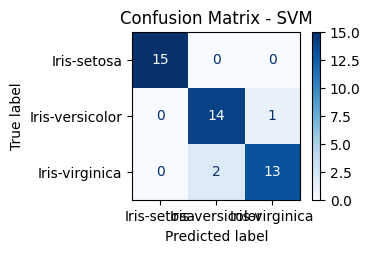

In [7]:
# Матрицы ошибок для лучшей модели
best_model_name = max(results.items(), key=lambda x: x[1]['accuracy'])[0]
best_model = results[best_model_name]['model']
y_pred_best = best_model.predict(X_test)

plt.subplot(2, 2, 2)
cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', ax=plt.gca())
plt.title(f'Confusion Matrix - {best_model_name}')


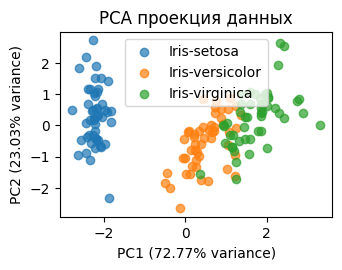

In [9]:
# PCA визуализация
plt.subplot(2, 2, 4)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(StandardScaler().fit_transform(X))
explained_variance = pca.explained_variance_ratio_

for i, class_name in enumerate(label_encoder.classes_):
    mask = y_encoded == i
    plt.scatter(X_pca[mask, 0], X_pca[mask, 1], label=class_name, alpha=0.7)

plt.xlabel(f'PC1 ({explained_variance[0]:.2%} variance)')
plt.ylabel(f'PC2 ({explained_variance[1]:.2%} variance)')
plt.title('PCA проекция данных')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
# 6. Детальный анализ лучшей модели
print(f"\n=== Детальный анализ лучшей модели: {best_model_name} ===")

# Classification report для лучшей модели
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best, target_names=label_encoder.classes_))



=== Детальный анализ лучшей модели: SVM ===

Classification Report:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00        15
Iris-versicolor       0.88      0.93      0.90        15
 Iris-virginica       0.93      0.87      0.90        15

       accuracy                           0.93        45
      macro avg       0.93      0.93      0.93        45
   weighted avg       0.93      0.93      0.93        45



In [11]:
# 7. Корректная функция для предсказания новых образцов
def predict_iris_sample(model, feature_names, label_encoder,
                       sepal_length, sepal_width,
                       petal_length, petal_width):
    """
    Предсказание для нового образца ириса
    """
    # Создаем DataFrame с правильными именами признаков
    sample_df = pd.DataFrame([[sepal_length, sepal_width, petal_length, petal_width]],
                            columns=feature_names)

    prediction = model.predict(sample_df)[0]
    probabilities = model.predict_proba(sample_df)[0]

    result = {
        'class': label_encoder.classes_[prediction],
        'prediction': prediction,
        'probabilities': dict(zip(label_encoder.classes_, probabilities)),
        'confidence': probabilities.max()
    }

    return result

In [12]:
# Тестирование на новых образцах
print("=== Тестирование на новых образцах ===")
test_samples = [
    [5.1, 3.5, 1.4, 0.2],  # setosa
    [6.3, 2.8, 5.1, 1.5],  # virginica
    [5.8, 2.7, 4.1, 1.0],  # versicolor
    [6.0, 3.0, 4.5, 1.5]   # Пограничный случай
]

for i, sample in enumerate(test_samples):
    result = predict_iris_sample(best_model, feature_names, label_encoder, *sample)
    print(f"Образец {i+1}:")
    print(f"  Признаки: sepal_length={sample[0]}, sepal_width={sample[1]}, "
          f"petal_length={sample[2]}, petal_width={sample[3]}")
    print(f"  Предсказанный класс: {result['class']}")
    print(f"  Уверенность: {result['confidence']:.3f}")
    print(f"  Все вероятности:")
    for class_name, prob in result['probabilities'].items():
        print(f"    {class_name}: {prob:.3f}")
    print()


=== Тестирование на новых образцах ===
Образец 1:
  Признаки: sepal_length=5.1, sepal_width=3.5, petal_length=1.4, petal_width=0.2
  Предсказанный класс: Iris-setosa
  Уверенность: 0.968
  Все вероятности:
    Iris-setosa: 0.968
    Iris-versicolor: 0.018
    Iris-virginica: 0.014

Образец 2:
  Признаки: sepal_length=6.3, sepal_width=2.8, petal_length=5.1, petal_width=1.5
  Предсказанный класс: Iris-versicolor
  Уверенность: 0.700
  Все вероятности:
    Iris-setosa: 0.011
    Iris-versicolor: 0.700
    Iris-virginica: 0.289

Образец 3:
  Признаки: sepal_length=5.8, sepal_width=2.7, petal_length=4.1, petal_width=1.0
  Предсказанный класс: Iris-versicolor
  Уверенность: 0.979
  Все вероятности:
    Iris-setosa: 0.016
    Iris-versicolor: 0.979
    Iris-virginica: 0.005

Образец 4:
  Признаки: sepal_length=6.0, sepal_width=3.0, petal_length=4.5, petal_width=1.5
  Предсказанный класс: Iris-versicolor
  Уверенность: 0.916
  Все вероятности:
    Iris-setosa: 0.012
    Iris-versicolor: 0.916


In [13]:
# 8. Анализ ошибок модели
print("=== Анализ ошибок ===")
misclassified_indices = np.where(y_test != y_pred_best)[0]

if len(misclassified_indices) > 0:
    print(f"Количество ошибок: {len(misclassified_indices)}")
    print("\nОшибочно классифицированные образцы:")

    X_test_df = X_test.iloc[misclassified_indices]
    y_test_true = y_test[misclassified_indices]
    y_pred_wrong = y_pred_best[misclassified_indices]

    for idx, (_, row) in enumerate(X_test_df.iterrows()):
        true_class = label_encoder.classes_[y_test_true[idx]]
        pred_class = label_encoder.classes_[y_pred_wrong[idx]]
        print(f"Образец {idx+1}:")
        print(f"  Признаки: {row.values}")
        print(f"  Истинный класс: {true_class}")
        print(f"  Предсказанный класс: {pred_class}")
        print()
else:
    print("Модель не совершила ни одной ошибки!")


=== Анализ ошибок ===
Количество ошибок: 3

Ошибочно классифицированные образцы:
Образец 1:
  Признаки: [6.3 2.8 5.1 1.5]
  Истинный класс: Iris-virginica
  Предсказанный класс: Iris-versicolor

Образец 2:
  Признаки: [6.7 3.  5.  1.7]
  Истинный класс: Iris-versicolor
  Предсказанный класс: Iris-virginica

Образец 3:
  Признаки: [4.9 2.5 4.5 1.7]
  Истинный класс: Iris-virginica
  Предсказанный класс: Iris-versicolor



In [14]:
# 9. Сохранение информации о модели
print(f"\n=== Итоги ===")
print(f"Лучшая модель: {best_model_name}")
print(f"Точность на тестовой выборке: {results[best_model_name]['accuracy']:.4f}")
print(f"Средняя точность при кросс-валидации: {results[best_model_name]['cv_mean']:.4f}")

# Информация о данных
print(f"\nИнформация о данных:")
print(f"Всего образцов: {len(X)}")
print(f"Признаки: {feature_names}")
print(f"Классы: {list(label_encoder.classes_)}")

# Дополнительная информация о лучшей модели
if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
    print(f"\nВажность признаков в лучшей модели:")
    feature_importance = best_model.named_steps['classifier'].feature_importances_
    for feature, importance in zip(feature_names, feature_importance):
        print(f"  {feature}: {importance:.4f}")


=== Итоги ===
Лучшая модель: SVM
Точность на тестовой выборке: 0.9333
Средняя точность при кросс-валидации: 0.9667

Информация о данных:
Всего образцов: 150
Признаки: ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
Классы: ['Iris-setosa', 'Iris-versicolor', 'Iris-virginica']
